# Community Detection

## Defination

Community detection is a fundamental task in network analysis that aims to identify groups of nodes (communities) that are more densely connected internally than with the rest of the network.

In many real-world systems—such as social networks, communication networks, and biological networks—nodes naturally form clusters based on shared characteristics or interactions. Detecting these communities helps reveal the underlying structure and organization of complex networks.

Typical applications include:

- Identifying social groups in online social networks
    
- Discovering functional modules in biological networks
    
- Analyzing information flow in communication networks
    

---

## Graph Representation

A network is commonly represented as a graph

$$\large G = (V, E)$$

where:

- $\large V$ is the set of nodes (e.g., users),
    
- $\large E$ is the set of edges representing relationships between nodes.
    

In this example, the network is modeled as an **undirected graph**, where an edge indicates a mutual relationship between two entities.

---

## Girvan–Newman Algorithm

The **Girvan–Newman algorithm** is a classic **divisive community detection** method based on the concept of **edge betweenness centrality**.

### Edge Betweenness Centrality

Edge betweenness measures how often an edge lies on the shortest paths between pairs of nodes.  
Edges with high betweenness typically act as “bridges” between communities.

Formally, the betweenness of an edge eee is defined as:

$$\large C_B(e) = \sum_{s \neq t} \frac{\sigma_{st}(e)}{\sigma_{st}}$$

where:

- $\large \sigma_{st}​$ is the total number of shortest paths between nodes sss and ttt,
    
- $\large \sigma_{st}(e)$ is the number of those paths that pass through edge eee.
    

---

## Algorithm Procedure

The Girvan–Newman algorithm follows these steps:

1. Compute edge betweenness centrality for all edges in the graph
    
2. Remove the edge with the highest betweenness
    
3. Recompute betweenness on the updated graph
    
4. Repeat until the network splits into multiple connected components
    

Each connected component obtained during this process represents a potential community.

---

## Modularity-Based Model Selection

To determine the most meaningful community structure, **modularity** is often used as a quality measure.

Modularity compares the density of edges inside communities with what would be expected in a random graph:

$$\large Q = \frac{1}{2m} \sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \mathbb{I}(c_i = c_j)$$

where:

- $\large A_{ij}$ is the adjacency matrix,
    
- $\large k_i$​ and $\large k_j$​ are node degrees,
    
- $\large m$ is the total number of edges,
    
- $\large \mathbb{I}(\cdot)$ is an indicator function.
    

Higher modularity values indicate stronger community structure.

In this example, the partition with the **highest modularity** during the edge removal process is selected as the final result.

---

## Key Characteristics

- **Unsupervised learning**: no labels are required
    
- **Graph-based method**: operates directly on network structure
    
- **Interpretable**: community boundaries correspond to removed “bridge” edges
    
- **Computationally intensive**: suitable for small to medium-sized graphs

# Data Loading

In this example, we use a real-world dataset obtained from **Kaggle**, which contains information about popular Instagram influencers, including their follower counts, categories, and geographic attributes.

Although the dataset is not originally provided as a network, it can be naturally transformed into a graph structure by defining relationships between influencers based on shared attributes. This makes it suitable for demonstrating **community detection algorithms** in a realistic setting. We first load the dataset and inspect its basic structure.

In [1]:
import pandas as pd
import numpy as np

# Load Kaggle dataset
data_path = "D:/研究生/机器学习/INDE-577/ml_project/examples/data/top_insta_influencers_data.csv"
df = pd.read_csv(data_path)

# Preview the dataset
df.head()
df.shape
df.columns

Index(['rank', 'channel_info', 'influence_score', 'posts', 'followers',
       'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes',
       'country'],
      dtype='object')

Typical columns in this dataset include:

- Influencer name or username
    
- Category or niche
    
- Country or region
    
- Number of followers
    

These attributes will later be used to define relationships between nodes in the network.

To keep the focus on the community detection algorithm, we apply only minimal preprocessing.

In [2]:
# Drop rows with missing key attributes
df_clean = df.dropna()

# Reset index
df_clean = df_clean.reset_index(drop=True)

df_clean.head()


,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
3,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States
4,6,kimkardashian,91,5.6k,329.2m,3.5m,0.88%,2.9m,19.9b,United States


The Girvan–Newman algorithm is computationally expensive.
To ensure reasonable runtime while preserving meaningful structure, we select a subset of the data.

Each influencer is treated as a node in the graph.

In [9]:
# Select a subset of influencers
n_samples = 150
df_sample = df_clean.iloc[:n_samples].copy()

df_sample.shape

# Assign a unique node id to each influencer
df_sample = df_sample.reset_index(drop=True)
df_sample["node_id"] = df_sample.index

df_sample.head()


,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country,node_id
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain,0
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States,1
2,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States,2
3,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States,3
4,6,kimkardashian,91,5.6k,329.2m,3.5m,0.88%,2.9m,19.9b,United States,4


Each influencer is treated as a node in the graph.

At this stage:

- Each row corresponds to one node
    
- No edges have been created yet

# Graph Construction

Community detection algorithms operate on graph-structured data.  
Since the Kaggle influencer dataset is not explicitly a network, we construct a graph by defining **relationships between influencers based on shared attributes**.

---

## Edge Definition Strategy

In this example, two influencers are connected if they:

- Belong to the **same category**, **or**
    
- Are from the **same country**
    

This simple rule creates a meaningful social structure where influencers with similar content focus or geographic background are more likely to be connected.

> **Design Choice**  
> This construction strategy is intuitive, interpretable, and sufficient for demonstrating community detection without introducing unnecessary complexity.

---

## Build Edge List

We construct an **undirected edge list** by iterating over all influencer pairs in the sampled dataset.

In [10]:
from itertools import combinations

edges = []

COUNTRY_COL = "country"
assert COUNTRY_COL in df_sample.columns

for i, j in combinations(df_sample.index, 2):
    same_country = (
        df_sample.loc[i, COUNTRY_COL] == df_sample.loc[j, COUNTRY_COL]
    )

    if same_country:
        u = df_sample.loc[i, "node_id"]
        v = df_sample.loc[j, "node_id"]
        edges.append((u, v))

len(edges)


2350

Since the graph is undirected, we remove duplicate edges to ensure consistency.

In [11]:
edges = list(set(edges))
len(edges)


2350

We now convert the edge list into an adjacency dictionary, which is the preferred input format for our community detection implementation.

In [12]:
adjacency = {}

for u, v in edges:
    adjacency.setdefault(u, []).append(v)
    adjacency.setdefault(v, []).append(u)


We perform a few basic checks to confirm that the graph is constructed correctly.

At this point:

- Each influencer corresponds to a node

- Edges represent shared category or country

- The graph is undirected and unweighted

In [13]:
num_nodes = len(adjacency)
num_edges = len(edges)

num_nodes, num_edges

# Inspect neighbors of a sample node
sample_node = list(adjacency.keys())[0]
sample_node, adjacency[sample_node][:10]

(13, [88, 55, 32, 68, 45, 22, 35, 133, 110, 11])

# Community Detection (Girvan–Newman)

With the constructed graph, we now apply the **Girvan–Newman community detection algorithm** to identify groups of influencers that are more densely connected within the network.

This algorithm iteratively removes edges with high betweenness centrality, progressively separating the graph into multiple communities.

---

## Apply Community Detection Model

We use the custom implementation of the **Girvan–Newman algorithm** provided in the `rice_ml` package.

In [14]:
from rice_ml.community_detection import GirvanNewmanCommunityDetection

# Initialize the model
model = GirvanNewmanCommunityDetection(
    keep_best_by_modularity=True,
    random_state=42
)

# Fit the model to the constructed graph
model.fit(adjacency)


GirvanNewmanCommunityDetection(n_communities=None, max_remove_steps=200, keep_best_by_modularity=True, random_state=42, communities_=[[1, 10, 108, 109, 11, 110, 112, 116, 12, 121, 125, 126, 127, 13, 133, 136, 14, 15, 17, 18, 19, 2, 20, 21, 22, 25, 27, 28, 29, 3, 30, 31, 32, 33, 35, 4, 41, 45, 46, 47, 49, 5, 55, 57, 6, 62, 66, 67, 68, 7, 71, 72, 75, 76, 80, 82, 83, 84, 85, 87, 88, 9, 90, 91, 98, 99], [101, 104, 122, 123, 135, 16, 40, 54, 56, 64, 86, 92, 93], [115, 131, 134, 52, 61, 79], [119, 132, 34, 37, 38, 39, 43, 51, 60, 65, 73, 94], [107, 26, 53, 63], [129, 36, 8], [0, 105, 23, 58, 97], [106, 111, 114, 137, 48, 69, 78], [50, 74, 96], [120, 124], [24, 70], [100, 44]], labels_={1: 0, 10: 0, 108: 0, 109: 0, 11: 0, 110: 0, 112: 0, 116: 0, 12: 0, 121: 0, 125: 0, 126: 0, 127: 0, 13: 0, 133: 0, 136: 0, 14: 0, 15: 0, 17: 0, 18: 0, 19: 0, 2: 0, 20: 0, 21: 0, 22: 0, 25: 0, 27: 0, 28: 0, 29: 0, 3: 0, 30: 0, 31: 0, 32: 0, 33: 0, 35: 0, 4: 0, 41: 0, 45: 0, 46: 0, 47: 0, 49: 0, 5: 0, 55: 0, 57: 

## Inspect Detected Communities

After fitting the model, we can examine the detected communities.

The modularity score provides a quantitative measure of the strength of the community structure.
Higher modularity values indicate more clearly defined communities.

In [15]:
# Number of detected communities
num_communities = len(model.communities_)
num_communities

# Modularity score of the selected partition
model.modularity_

0.17761747397011482

## Community Assignments

Each node (influencer) is assigned a community label.

This output shows how influencers are distributed across the detected communities.

In [16]:
labels = model.predict(adjacency)
labels[:10]

# Count nodes per community
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{0: 66, 1: 13, 2: 6, 3: 12, 4: 4, 5: 3, 6: 5, 7: 7, 8: 3, 9: 2, 10: 2, 11: 2}

## Examine a Sample Community

We can inspect the members of a specific community.

Each community represents a group of influencers that are closely connected based on shared country information.

In [17]:
# Select a community to inspect
community_id = unique[0]

# Nodes belonging to this community
community_nodes = [
    node for node, label in model.labels_.items()
    if label == community_id
]

len(community_nodes), community_nodes[:10]


(66, [1, 10, 108, 109, 11, 110, 112, 116, 12, 121])

# Visualization of Communities

Visualization helps us better understand the structure of the detected communities.  
Instead of plotting the full network graph, which can be visually cluttered and computationally unstable, we focus on **interpretable summary visualizations**.

---

## Community Size Distribution

We first visualize the number of nodes (influencers) in each detected community.
This bar chart provides a clear overview of how the influencer network is partitioned into communities.

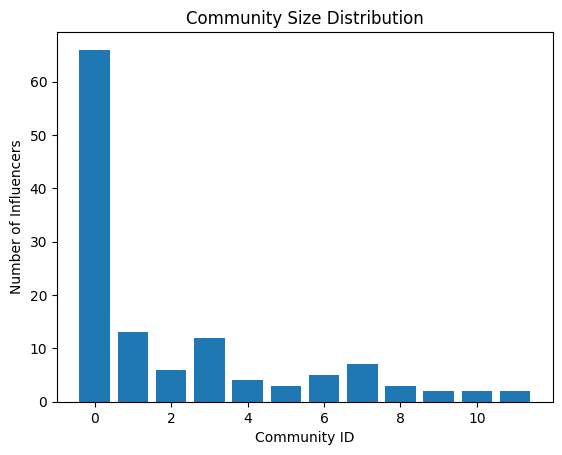

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Count nodes per community
community_ids, community_sizes = np.unique(labels, return_counts=True)

community_ids, community_sizes

# Bar chart of community sizes
plt.figure()
plt.bar(community_ids, community_sizes)
plt.xlabel("Community ID")
plt.ylabel("Number of Influencers")
plt.title("Community Size Distribution")
plt.show()


## Community Membership Overview

To further interpret the communities, we map community labels back to the original influencer data.

In [20]:
# Build node_id -> community mapping
node_to_community = model.labels_

# Assign community labels back to the dataframe
# Influencers not appearing in the graph (isolated nodes) get label -1
df_sample["community"] = (
    df_sample["node_id"]
    .map(node_to_community)
    .fillna(-1)
    .astype(int)
)

df_sample[["channel_info", "country", "community"]].head()


,channel_info,country,community
0,cristiano,Spain,6
1,kyliejenner,United States,0
2,selenagomez,United States,0
3,therock,United States,0
4,kimkardashian,United States,0


## Country Composition Within Communities

Since the graph was constructed based on country similarity, we examine how countries are distributed across communities.
This table shows the number of influencers from each country within each detected community.

In [21]:
# Country distribution per community
community_country_dist = (
    df_sample
    .groupby(["community", "country"])
    .size()
    .unstack(fill_value=0)
)

community_country_dist


country,Anguilla,Australia,Brazil,British Virgin Islands,Canada,Colombia,Czech Republic,CÃ´te d'Ivoire,France,Germany,...,Puerto Rico,Russia,Spain,Sweden,Switzerland,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay
community,,,,,,,,,,,,,,,,,,,,,
-1,1,1,0,1,0,0,1,1,0,1,...,1,1,0,1,1,0,1,0,0,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,66,0
1,0,0,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
5,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Summary & Key Takeaways

> In this example, we applied the Girvan–Newman community detection algorithm to a real-world Kaggle dataset of top Instagram influencers.
> 
> Since the original dataset is tabular rather than graph-structured, we constructed a network by connecting influencers from the same country. This transformation allowed us to study the network structure using graph-based methods.
> 
> The results show that influencers are grouped into communities largely aligned with geographic regions. Influencers from countries with many representatives form large, dense communities, while countries with fewer influencers form smaller communities. Influencers whose country appears only once in the dataset are treated as isolated nodes and are not assigned to any community.
> 
> These results demonstrate both the effectiveness of the Girvan–Newman algorithm and the importance of graph construction choices when applying community detection to real-world data.